# Module 8: Storm Frequency Analysis - Spring vs Fall

This module will be to compare the number of severe weather events in Texas between meterological fall and spring over the state of Texas over the past 70 years.
Using the most broad filter of "Thunderstorm Wind": Any estimated or measured wind gust over 51 knots or ~58 mph.
We will:
1. Load NOAA Storm Events data
2. Parse dates in UTC
3. Classify events into seasons
4. Aggregate yearly counts
5. Visualize time series
6. Plot event locations on a Texas map



# Step 1: Import/Install Packages

In [4]:
# You may need to install geopandas if you haven't already as it is not included in the xarray-climate environment

!pip install geopandas plotly
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import plotly.express as px

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Step 2: Import Storm Data

In [5]:
df = pd.read_csv("Data\storm_data_search_results.csv")
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\tomy3\AppData\Local\Temp\ipykernel_18700\2058581401.py:1: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv("Data\storm_data_search_results.csv")


,EVENT_ID,BEGIN_DATE,BEGIN_TIME,BEGIN_LAT,BEGIN_LON,Unnamed: 5
0,10119365,3/20/1955,1500,29.08,-98,NaN
1,10119367,3/20/1955,1600,29.48,-98.5,NaN
2,10119370,3/20/1955,1815,30.58,-96.28,NaN
3,10119371,3/20/1955,1955,32.5,-94.68,NaN
4,10119374,3/31/1955,1415,33.5,-97,NaN


# Step 3: Parse Dates and Classify Seasons
The NOAA dataset stores event start times in two separate columns: `BEGIN_DATE` and `BEGIN_TIME`.  
We need to combine these into a single datetime column (`BEGIN_DATE_TIME`), convert to UTC, and then extract the year and month.  
Finally, we classify each event into meteorological **spring (Mar–May)** or **fall (Sep–Nov)**.

In [6]:
# Combine BEGIN_DATE and BEGIN_TIME into one datetime column
df["BEGIN_DATE_TIME"] = pd.to_datetime(
    df["BEGIN_DATE"].astype(str) + " " + df["BEGIN_TIME"].astype(str),
    utc=True,
    errors="coerce"
)

# Drop rows with invalid datetime and make a copy to avoid SettingWithCopyWarning
df = df.dropna(subset=["BEGIN_DATE_TIME"]).copy()

# Extract year and month
df["year"] = df["BEGIN_DATE_TIME"].dt.year
df["month"] = df["BEGIN_DATE_TIME"].dt.month

# Classify seasons
def classify_season(month):
    if month in [3, 4, 5]:
        return "spring"
    elif month in [9, 10, 11]:
        return "fall"
    else:
        return "other"

df["season"] = df["month"].apply(classify_season)

# Quick check
df[["BEGIN_DATE", "BEGIN_TIME", "BEGIN_DATE_TIME", "year", "month", "season"]].head()

,BEGIN_DATE,BEGIN_TIME,BEGIN_DATE_TIME,year,month,season
0,3/20/1955,1500,1955-03-20 15:00:00+00:00,1955,3,spring
1,3/20/1955,1600,1955-03-20 16:00:00+00:00,1955,3,spring
2,3/20/1955,1815,1955-03-20 18:15:00+00:00,1955,3,spring
3,3/20/1955,1955,1955-03-20 19:55:00+00:00,1955,3,spring
4,3/31/1955,1415,1955-03-31 14:15:00+00:00,1955,3,spring


# Step 4: Aggregate Counts by Year and Season

Now that each event has been tagged with a season, we can count how many thunderstorm wind events occurred in **spring** and **fall** each year.  
This aggregation will let us compare seasonal storm frequencies over time.

In [7]:
# Keep only spring and fall events
seasonal_df = df[df["season"].isin(["spring", "fall"])]

# Group by year and season, count events
counts = (
    seasonal_df
    .groupby(["year", "season"])
    .size()
    .reset_index(name="events")
)

# Pivot table: years as rows, seasons as columns
pivot = counts.pivot(index="year", columns="season", values="events").fillna(0)

# Add difference and ratio columns
pivot["Difference"] = pivot.get("fall", 0) - pivot.get("spring", 0)
pivot["Ratio_Fall_to_Spring"] = pivot.get("fall", 0) / pivot.get("spring", 1)

# Preview the first few rows
pivot.head()

season,fall,spring,Difference,Ratio_Fall_to_Spring
year,,,,
1955,3.0,30.0,-27.0,0.100000
1956,16.0,22.0,-6.0,0.727273
1957,17.0,55.0,-38.0,0.309091
1958,17.0,41.0,-24.0,0.414634
1959,8.0,31.0,-23.0,0.258065


^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
The resulting table shows:
- **Spring** and **Fall** counts per year
- **Difference** (Fall − Spring)
- **Ratio** (Fall / Spring)

# Step 5: Plot Time Series

With the aggregated counts, we can now visualize how thunderstorm wind events vary between **spring** and **fall** over time.  
This plot will help us see whether fall events are increasing relative to spring, or if spring remains dominant.

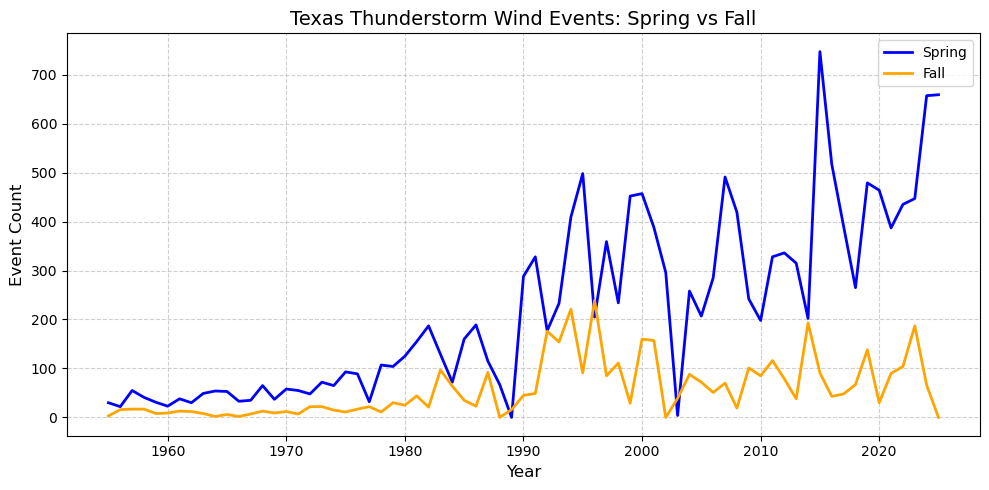

In [8]:
# Create the time series plot
plt.figure(figsize=(10,5))
plt.plot(pivot.index, pivot.get("spring", 0), label="Spring", color="blue", linewidth=2)
plt.plot(pivot.index, pivot.get("fall", 0), label="Fall", color="orange", linewidth=2)

# Add labels and title
plt.title("Texas Thunderstorm Wind Events: Spring vs Fall", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Event Count", fontsize=12)

# Add legend and grid
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

The plot shows the number of thunderstorm wind events in Texas for each year, separated by season:
- **Blue line** → Spring (Mar–May)
- **Orange line** → Fall (Sep–Nov)
Two things should appear here in this data, can you infer why, even between both seasons, count increases overall with time?

# Step 6: Interactive Texas Map with County Boundaries

To explore seasonal storm distributions interactively, we’ll use Plotly.  
This lets us:
- Toggle **spring** and **fall** events on/off with the legend
- Use a **year slider** to filter events by year
- Overlay **Texas county boundaries** for geographic context

In [9]:
# --- Clean coordinates ---
df["BEGIN_LAT"] = pd.to_numeric(df["BEGIN_LAT"], errors="coerce")
df["BEGIN_LON"] = pd.to_numeric(df["BEGIN_LON"], errors="coerce")
df = df.dropna(subset=["BEGIN_LAT","BEGIN_LON"]).copy()
df = df[df["BEGIN_LAT"].between(25,37) & df["BEGIN_LON"].between(-107,-93)].copy()

# Keep only spring/fall
plot_df = df[df["season"].isin(["spring","fall"])].copy()

# --- Load Texas counties as GeoJSON ---
# Use Census Bureau cartographic boundary file (5m resolution)
# Download: https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip
counties = gpd.read_file("Data/cb_2018_us_county_5m.shp")
tx_counties = counties[counties["STATEFP"] == "48"]

# Convert to GeoJSON for Plotly
tx_geojson = tx_counties.__geo_interface__

# --- Interactive scatter map ---
fig = px.scatter_mapbox(
    plot_df,
    lat="BEGIN_LAT",
    lon="BEGIN_LON",
    color="season",
    hover_data=["year","EVENT_ID"],
    animation_frame="year",   # slider by year
    zoom=5,
    height=700,
    title="Texas Thunderstorm Wind Events by Season"
)

# Add county boundaries overlay
fig.update_layout(
    mapbox_style="carto-positron",
    mapbox_layers=[
        {
            "source": tx_geojson,
            "type": "line",
            "color": "lightgray",
            "line": {"width": 1}
        }
    ],
    legend_title="Season",
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig.show()

C:\Users\tomy3\AppData\Local\Temp\ipykernel_18700\2701270420.py:20: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(


# Step 7: Statistical Testing

Visual inspection suggests differences between spring and fall storm counts, but we need to test this formally.  
We’ll use a **chi-square test of independence** to compare seasonal frequencies across years.  
This will tell us whether the distribution of events between spring and fall is significantly different from what would be expected by chance.

In [15]:
from scipy.stats import chi2_contingency, linregress
import pandas as pd

# --- Chi-square test ---
seasonal_df = df[df["season"].isin(["spring","fall"])].copy()
contingency = pd.crosstab(seasonal_df["year"], seasonal_df["season"])

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)
if p < 0.05:
    print("Result: Significant difference between spring and fall frequencies across years.")
else:
    print("Result: No significant difference detected between spring and fall frequencies across years.")

# --- Trend analysis ---
pivot = contingency.copy()
pivot = pivot.fillna(0)

spring_trend = linregress(pivot.index, pivot.get("spring", 0))
fall_trend = linregress(pivot.index, pivot.get("fall", 0))

print("\nSpring trend slope:", spring_trend.slope, "events/year")
print("Fall trend slope:", fall_trend.slope, "events/year")

if fall_trend.slope > spring_trend.slope:
    print("Fall events are increasing faster than spring events.")
else:
    print("Spring events are increasing faster or fall is not keeping pace.")

Chi-square statistic: 2100.386404940607
Degrees of freedom: 67
p-value: 0.0
Result: Significant difference between spring and fall frequencies across years.

Spring trend slope: 7.173202859773857 events/year
Fall trend slope: 1.42781007560458 events/year
Spring events are increasing faster or fall is not keeping pace.


The chi-square test tells us whether spring vs fall distributions differ significantly across years.  
The regression slopes quantify whether one season is trending upward faster than the other.  

Together, these analyses answer:
- **Are seasonal differences real or random?** (chi-square)
- **Which season is gaining more events over time?** (regression)

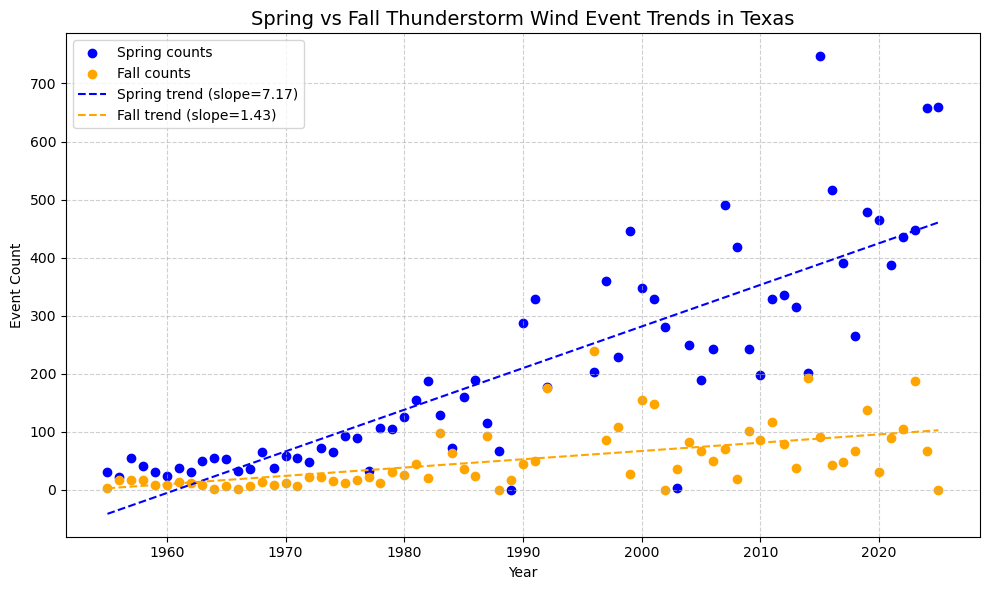

Spring slope: 7.173202859773857 events/year
Fall slope: 1.42781007560458 events/year


In [14]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

# Build contingency table
seasonal_df = df[df["season"].isin(["spring","fall"])].copy()
contingency = pd.crosstab(seasonal_df["year"], seasonal_df["season"]).fillna(0)

years = contingency.index

# Regression for spring
spring_counts = contingency.get("spring", 0)
spring_reg = linregress(years, spring_counts)

# Regression for fall
fall_counts = contingency.get("fall", 0)
fall_reg = linregress(years, fall_counts)

# Plot counts + regression lines
plt.figure(figsize=(10,6))
plt.scatter(years, spring_counts, color="blue", label="Spring counts")
plt.scatter(years, fall_counts, color="orange", label="Fall counts")

plt.plot(years, spring_reg.intercept + spring_reg.slope*years,
         color="blue", linestyle="--", label=f"Spring trend (slope={spring_reg.slope:.2f})")
plt.plot(years, fall_reg.intercept + fall_reg.slope*years,
         color="orange", linestyle="--", label=f"Fall trend (slope={fall_reg.slope:.2f})")

plt.title("Spring vs Fall Thunderstorm Wind Event Trends in Texas", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Event Count")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Print regression results
print("Spring slope:", spring_reg.slope, "events/year")
print("Fall slope:", fall_reg.slope, "events/year")